In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyscf import gto, dft
import os
from ase import Atoms
from ase.io import read, write

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Plot the training losses for the PBE0 and SCAN pre-trained networks.

In [2]:
hart_to_kcal_mol = 627.5096080305927 #kcal/mol per hartree

spins_dict = {
    'Al': 1,
    'B' : 1,
    'Li': 1,
    'Na': 1,
    'Si': 2 ,
    'Be':0,
    'C': 2,
    'Cl': 1,
    'F': 1,
    'H': 1,
    'N': 3,
    'O': 2,
    'P': 3,
    'S': 2,
    'Ar':0, #noble
    'Br':1, #one unpaired electron
    'Ne':0, #noble
    'Sb':3, #same column as N/P
    'Bi':3, #same column as N/P/Sb
    'Te':2, #same column as O/S
    'I':1 #one unpaired electron
}


def get_spin(at, vvv=False):
    #tries to use information present in the at.info dictionary to guess spin
    #if single atom and spin is not specified in at.info dictionary, use spins_dict
    if vvv:
        print('======================')
        print("GET SPIN: Atoms Info")
        print(at)
        print(at.info)
        print('======================')
    if ( (len(at.positions) == 1) and not ('spin' in at.info) ):
        # print("Single atom and no spin specified in at.info")
        spin = spins_dict[str(at.symbols)]
    else:
        # print("Not a single atom, or spin in at.info")
        if type(at.info.get('spin', None)) == type(0):
            #integer specified in at.info['spin'], so use it
            # print('Spin specified in atom info.')
            spin = at.info['spin']
        elif 'radical' in at.info.get('name', ''):
            #radicals are species with a single unpair electron
            # print('Radical specified in atom.info["name"], assuming spin 1.')
            spin = 1
        elif at.info.get('openshell', None):
            # print("Openshell specified in atom info, attempting spin 2.")
            spin = 2
        else:
            # print("No specifications in atom info to help, assuming no spin.")
            spin = 0
    return spin

def gen_mol(atoms=None, sym=None, BASIS = '6-311++G(3df,2pd)'):
    if atoms:
        molsym = str(at.symbols)
        syms = at.get_chemical_symbols()
        pos = at.get_positions()
        form = at.get_chemical_formula()
    else:
        molsym = sym
        syms = [sym]
        pos = [0,0,0]
        form = sym
    mol = gto.Mole()
    mol_atom_list = []
    for isym, sym in enumerate(syms):
        mol_atom_list.append([sym, pos[isym]])
    mol.atom = mol_atom_list
    mol.basis = BASIS
    molgen = False
    scount = 0
    while not molgen:
        # print(scount)
        try:
            # print("Trying spin = {} - {} = {}".format(get_spin(at), scount, get_spin(at)-scount))
            mol.spin = get_spin(at)-scount
            mol.charge = at.info.get('charge', 0)
            mol.verbose = 1
            mol.build()
            molgen = True
        except RuntimeError:
            scount += 1
            if get_spin(at)-scount < 0:
                raise ValueError 
    return mol

def get_rho(dm, ao_eval, nelec):
        # print("AO_EVAL, DM SHAPES: {}. {}.".format(ao_eval.shape, dm.shape))
        if len(dm.shape) == 2:
            # print("2D DM.")
            # print("RESULTS N_ELEC: ", nelec)
            rho = np.einsum('ij,ik,jk->i',
                               ao_eval, ao_eval, dm)
        else:
            # print("NON-2D DM")
            rho = np.einsum('ij,ik,xjk->xi',
                               ao_eval, ao_eval, dm)
        return rho


def smooth(y, box_pts, pad=True):
    #https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
    
    box = np.ones(box_pts)/box_pts
    if pad:
        print('Padding input array -- {} on each side with edge values.'.format(box_pts))
        print('Former shape: {}'.format(y.shape))
        y = np.pad(y, box_pts, mode='edge')
        print('Padded shape: {}'.format(y.shape))
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts:-box_pts]

td = '/home/awills/Documents/Research/xcquinox_pt'
xcs = ['pbe0', 'scan']
netdirs = sorted([i for i in os.listdir(os.path.join(td,'pbe0')) if os.path.isdir(os.path.join(td, 'pbe0', i))])

In [3]:
netdirs

['c_3_16_mgga',
 'c_3_16_mgga_lr2',
 'c_3_16_nl',
 'c_3_16_nl_lr2',
 'c_3_16_nl_lr2_use2',
 'c_3_32_mgga',
 'c_3_32_mgga_lr2',
 'c_3_32_nl',
 'c_3_32_nl_lr2',
 'c_3_32_nl_lr2_use2',
 'c_4_16_mgga',
 'c_4_16_mgga_lr2',
 'c_4_16_nl',
 'c_4_16_nl_lr2',
 'c_4_16_nl_lr2_use2',
 'c_4_32_mgga',
 'c_4_32_mgga_lr2',
 'c_4_32_nl',
 'c_4_32_nl_lr2',
 'c_4_32_nl_lr2_use2',
 'x_3_16_mgga',
 'x_3_16_mgga_lr2',
 'x_3_16_nl',
 'x_3_16_nl_lr2',
 'x_3_16_nl_lr2_use2',
 'x_3_32_mgga',
 'x_3_32_mgga_lr2',
 'x_3_32_nl',
 'x_3_32_nl_lr2',
 'x_3_32_nl_lr2_use2',
 'x_4_16_mgga',
 'x_4_16_mgga_lr2',
 'x_4_16_nl',
 'x_4_16_nl_lr2',
 'x_4_16_nl_lr2_use2',
 'x_4_32_mgga',
 'x_4_32_mgga_lr2',
 'x_4_32_nl',
 'x_4_32_nl_lr2',
 'x_4_32_nl_lr2_use2']

c_3_16_mgga
pbe0
(2500, 2)
MGGA (3x16)$^\{\}$
Padding input array -- 20 on each side with edge values.
Former shape: (2500,)
Padded shape: (2540,)
scan
(1607, 2)
MGGA (3x16)$^\{\}$
Padding input array -- 20 on each side with edge values.
Former shape: (1607,)
Padded shape: (1647,)
c_3_16_mgga_lr2
pbe0
(10000, 2)
MGGA (3x16)$^\{*\}$
Padding input array -- 20 on each side with edge values.
Former shape: (10000,)
Padded shape: (10040,)
scan
not found:  /home/awills/Documents/Research/xcquinox_pt scan c_3_16_mgga_lr2
c_3_16_nl
pbe0
(5000, 2)
NL (3x16)$^\{\}$
Padding input array -- 20 on each side with edge values.
Former shape: (5000,)
Padded shape: (5040,)
scan
(5000, 2)
NL (3x16)$^\{\}$
Padding input array -- 20 on each side with edge values.
Former shape: (5000,)
Padded shape: (5040,)
c_3_16_nl_lr2
pbe0
(10000, 2)
NL (3x16)$^\{*\}$
Padding input array -- 20 on each side with edge values.
Former shape: (10000,)
Padded shape: (10040,)
scan
not found:  /home/awills/Documents/Research/xcqui

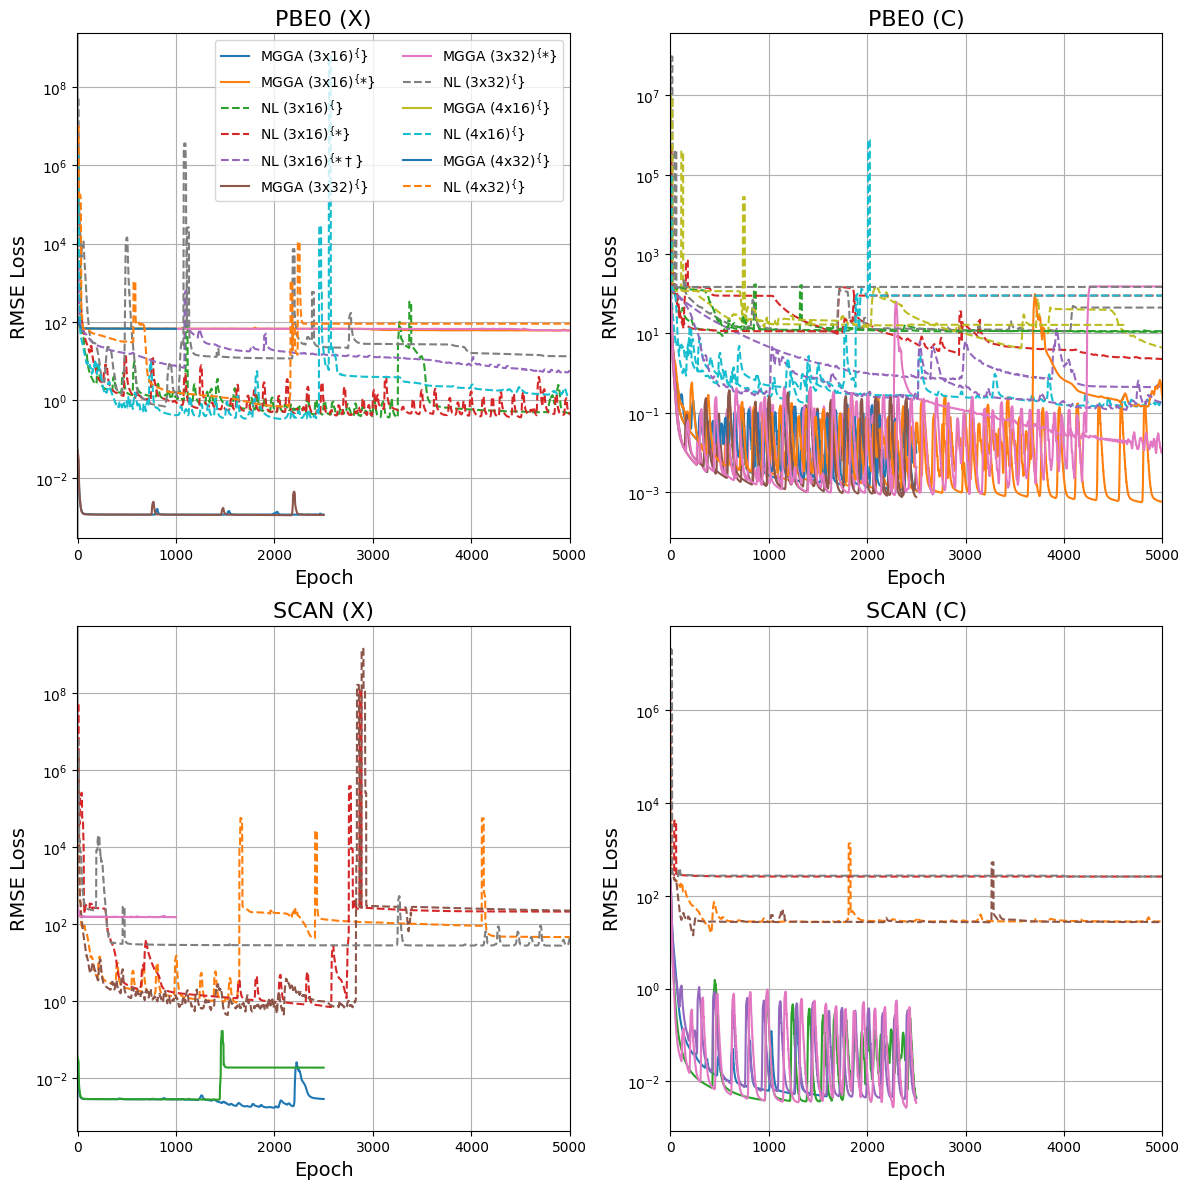

In [4]:
f = plt.figure(figsize=(12,12))
axpx = f.add_subplot(221)
axpc = f.add_subplot(222)
axsx = f.add_subplot(223)
axsc = f.add_subplot(224)

axs = [axpx,axpc,axsx,axsc]

axpx.set_title('PBE0 (X)', fontsize=16)
axpc.set_title('PBE0 (C)', fontsize=16)
axsx.set_title('SCAN (X)', fontsize=16)
axsc.set_title('SCAN (C)', fontsize=16)

lss = {'mgga':'-',
       'nl':'--'}


for ax in axs:
    ax.grid()
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('RMSE Loss', fontsize=14)
    ax.set_yscale('log')
    ax.set_xlim(-1, 5000)

smoothpts = 20

for nd in netdirs:
    print(nd)
    nd_split = nd.split('_')
    if len(nd_split) == 4:
        #xorc_depth_nodes_level    
        xorc, depth, nodes, level = nd_split
        lr2 = ''
        use = ''
    elif len(nd_split) == 5:
        #xorc_depth_nodes_level_lr2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2 = nd_split
        use = ''
    elif len(nd_split) == 6:
        #xorc_depth_nodes_level_lr2_use2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2, use = nd_split
    for ixc, xc in enumerate(xcs):
        print(xc)
        try:
            loss = pd.read_csv(os.path.join(td, xc, nd, 'ptlog.dat'), delimiter='\t')
            print(loss.shape)
        except:
            print('not found: ', td, xc, nd)
            continue
        ls = lss[level]
        #no nl rn
        if xc == 'pbe0':
            if nd[0] == 'x':
                ax = axpx
            elif nd[0] == 'c':
                ax = axpc
        elif xc == 'scan':
            if nd[0] == 'x':
                ax = axsx
            elif nd[0] == 'c':
                ax = axsc
        lr2m = '*' if lr2 else ''
        use2m = '\dagger' if use else ''
        lab = f'{level.upper()} ({depth}x{nodes})'+'$^\{'+f'{lr2m}'+f'{use2m}'+'\}$'
        print(lab)
        if not smoothpts:
            ax.plot(loss['#Epoch'], loss['Loss'], ls=ls, label=lab)
        else:
            ax.plot(loss['#Epoch'], smooth(loss['Loss'], smoothpts), ls=ls, label=lab)

axs[0].legend(ncol=2)
plt.tight_layout()

Just for PBE0 training, since more of it

c_3_16_mgga
pbe0
(2500, 2)
['PBE0', '3', '16  ', 2500, 2373, 'xmrmse', -2.9497689690290954, 'xnrmse', 'cnrmse']
(3x16)$^{  }$
Padding input array -- 50 on each side with edge values.
Former shape: (2500,)
Padded shape: (2600,)
scan
(1607, 2)
['SCAN', '3', '16  ', 1607, 1591, 'xmrmse', -2.3224477784876996, 'xnrmse', 'cnrmse']
c_3_16_mgga_lr2
pbe0
(10000, 2)
['PBE0', '3', '16* ', 10000, 9992, 'xmrmse', -3.5854470180532294, 'xnrmse', 'cnrmse']
(3x16)$^{* }$
Padding input array -- 50 on each side with edge values.
Former shape: (10000,)
Padded shape: (10100,)
scan
not found:  /home/awills/Documents/Research/xcquinox_pt scan c_3_16_mgga_lr2
c_3_16_nl
pbe0
(5000, 2)
['PBE0', '3', '16  ', 5000, 568, 'xmrmse', 'cmrmse', 'xnrmse', 0.856548486754906]
(3x16)$^{  }$
Padding input array -- 50 on each side with edge values.
Former shape: (5000,)
Padded shape: (5100,)
scan
(5000, 2)
['SCAN', '3', '16  ', 5000, 424, 'xmrmse', 'cmrmse', 'xnrmse', 1.1407111684080176]
c_3_16_nl_lr2
pbe0
(10000, 2)
['PBE0

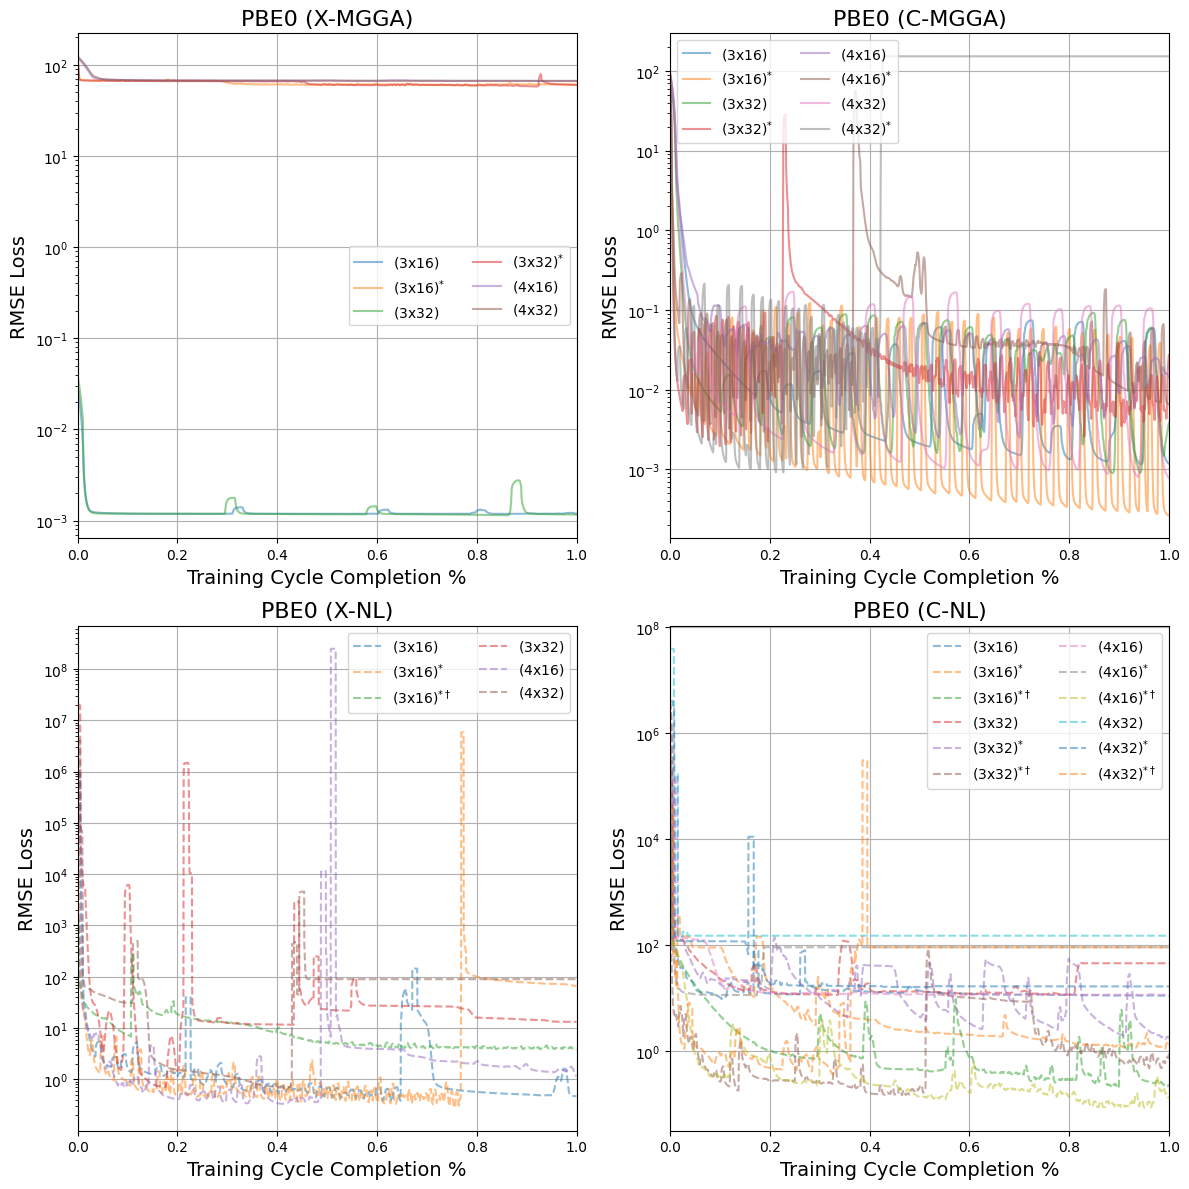

In [5]:
f = plt.figure(figsize=(12,12))
axpx = f.add_subplot(221)
axpc = f.add_subplot(222)
axsx = f.add_subplot(223)
axsc = f.add_subplot(224)

axs = [axpx,axpc,axsx,axsc]

axpx.set_title('PBE0 (X-MGGA)', fontsize=16)
axpc.set_title('PBE0 (C-MGGA)', fontsize=16)
axsx.set_title('PBE0 (X-NL)', fontsize=16)
axsc.set_title('PBE0 (C-NL)', fontsize=16)

lss = {'mgga':'-',
       'nl':'--'}


for ax in axs:
    ax.grid()
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('RMSE Loss', fontsize=14)
    ax.set_yscale('log')
    ax.set_xlim(-1, 10000)

smoothpts = 50
df_lists = []
xc_cats = []
for nd in netdirs:
    print(nd)
    nd_split = nd.split('_')
    if len(nd_split) == 4:
        #xorc_depth_nodes_level    
        xorc, depth, nodes, level = nd_split
        lr2 = ''
        use = ''
    elif len(nd_split) == 5:
        #xorc_depth_nodes_level_lr2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2 = nd_split
        use = ''
    elif len(nd_split) == 6:
        #xorc_depth_nodes_level_lr2_use2, just denotes a different learning rate schedule used    
        xorc, depth, nodes, level, lr2, use = nd_split
    lr2m = '*' if lr2 else ' '
    use2m = '\dagger' if use else ' '
    for ixc, xc in enumerate(xcs):
        df_list = ['xcf', 'depth','nhidden','numepochs','minepoch', 'xmrmse', 'cmrmse', 'xnrmse', 'cnrmse']
        df_list[1] = depth
        df_list[2] = nodes+lr2m+use2m
        print(xc)
        try:
            loss = pd.read_csv(os.path.join(td, xc, nd, 'ptlog.dat'), delimiter='\t')
            df_list[3] = len(loss['Loss'])
            df_list[4] = loss[loss['Loss'] == loss['Loss'].min()]['#Epoch'].values[0]
            print(loss.shape)
            if level == 'mgga':
                if xorc == 'x':
                    df_list[5] = np.log10(loss['Loss'].min())
                elif xorc == 'c':
                    df_list[6] = np.log10(loss['Loss'].min())
            elif level == 'nl':
                if xorc == 'x':
                    df_list[7] = np.log10(loss['Loss'].min())
                elif xorc == 'c':
                    df_list[8] = np.log10(loss['Loss'].min())
        except:
            print('not found: ', td, xc, nd)
            continue
        #pre-plot, extract information for table
        df_list[0] = xc.upper()
        xc_cats.append(xc)
        df_lists.append(df_list)
        print(df_list)
        if xc == 'scan':
            continue
        ls = lss[level]
        #no nl rn
        if level == 'mgga':
            if nd[0] == 'x':
                ax = axpx
            elif nd[0] == 'c':
                ax = axpc
        elif level == 'nl':
            if nd[0] == 'x':
                ax = axsx
            elif nd[0] == 'c':
                ax = axsc
        lab = f'({depth}x{nodes})'+'$^{'+f'{lr2m}'+f'{use2m}'+'}$'
        print(lab)
        x_norm = max(loss['#Epoch'])
        # x_norm = 1
        ALPHA = 0.5
        if not smoothpts:
            ax.plot(loss['#Epoch']/x_norm, loss['Loss'], ls=ls, label=lab, alpha=ALPHA)
        else:
            ax.plot(loss['#Epoch']/x_norm, smooth(loss['Loss'], smoothpts), ls=ls, label=lab, alpha=ALPHA)

for ax in axs:
    ax.legend(ncol=2)
    if (x_norm - 1):
        ax.set_xlim(0, 1)
        ax.set_xlabel('Training Cycle Completion %', fontsize=14)


plt.tight_layout()

In [6]:
thesis_df = pd.DataFrame(df_lists, columns=['xcf', 'depth','nhidden','numepochs','minepoch', 'xmrmse', 'cmrmse', 'xnrmse', 'cnrmse'])

In [7]:
print(thesis_df.sort_values(['xcf', 'depth', 'nhidden']).to_latex(index=False))

\begin{tabular}{lllrrllll}
\toprule
xcf & depth & nhidden & numepochs & minepoch & xmrmse & cmrmse & xnrmse & cnrmse \\
\midrule
PBE0 & 3 & 16   & 2500 & 2373 & xmrmse & -2.949769 & xnrmse & cnrmse \\
PBE0 & 3 & 16   & 5000 & 568 & xmrmse & cmrmse & xnrmse & 0.856548 \\
PBE0 & 3 & 16   & 2500 & 2450 & -2.929070 & cmrmse & xnrmse & cnrmse \\
PBE0 & 3 & 16   & 5000 & 3250 & xmrmse & cmrmse & -0.454515 & cnrmse \\
PBE0 & 3 & 16*  & 10000 & 9992 & xmrmse & -3.585447 & xnrmse & cnrmse \\
PBE0 & 3 & 16*  & 10000 & 9951 & xmrmse & cmrmse & xnrmse & 0.022910 \\
PBE0 & 3 & 16*  & 10000 & 8190 & 1.771312 & cmrmse & xnrmse & cnrmse \\
PBE0 & 3 & 16*  & 10000 & 7649 & xmrmse & cmrmse & -0.574286 & cnrmse \\
PBE0 & 3 & 16*\dagger & 10000 & 8982 & xmrmse & cmrmse & xnrmse & -0.753171 \\
PBE0 & 3 & 16*\dagger & 10000 & 9985 & xmrmse & cmrmse & 0.569836 & cnrmse \\
PBE0 & 3 & 32   & 2500 & 2466 & xmrmse & -3.088486 & xnrmse & cnrmse \\
PBE0 & 3 & 32   & 5000 & 1703 & xmrmse & cmrmse & xnrmse & 1.02144

In [49]:
thesis_df

,xcf,depth,nhidden,num_epochs,min_epoch,xm_rmse,cm_rmse,xn_rmse,cn_rmse
0,scan,3,16,1607,1591,xm_rmse,-2.322448,xn_rmse,cn_rmse
1,scan,3,16,1607,1591,xm_rmse,-2.322448,xn_rmse,cn_rmse
2,pbe0,3,16*,10000,9992,xm_rmse,-3.585447,xn_rmse,cn_rmse
3,scan,3,16,5000,424,xm_rmse,cm_rmse,xn_rmse,1.140711
4,scan,3,16,5000,424,xm_rmse,cm_rmse,xn_rmse,1.140711
5,pbe0,3,16*,10000,9951,xm_rmse,cm_rmse,xn_rmse,0.02291
6,pbe0,3,16*\dagger,8651,8111,xm_rmse,cm_rmse,xn_rmse,-0.623465
7,scan,3,32,2500,2484,xm_rmse,-2.483112,xn_rmse,cn_rmse
8,scan,3,32,2500,2484,xm_rmse,-2.483112,xn_rmse,cn_rmse
9,pbe0,3,32*,10000,9949,xm_rmse,-3.082095,xn_rmse,cn_rmse


To plot the calculate_traj.py results

In [194]:
td = '/home/awills/Documents/Research/xcquinox_pt/g297_val'
# xcs = ['pbe0', 'scan']
xcs = ['pbe0']
archs = ['3_16_mgga', '3_32_mgga', '3_16_nl', '3_32_nl']
grids = ['grid1', 'grid3']
# reft = read(os.path.join(td, 'g2_97.traj'), ':')
reft = read(os.path.join(td, 'g2_97_sw.traj'), ':')
refatoms = []
for idx, mol in enumerate(reft):
    refatoms += mol.get_chemical_symbols()
refatoms = set(refatoms)
refatoms = sorted(list(refatoms))
tot_ref = refatoms + reft

In [92]:
g297dir = '/home/awills/Documents/Research/xcquinox_pt/g297_val/g2_97_ccsdt'
s_ae_devs = {d:0 for d in archs}
s_dm_devs = {d:0 for d in archs}
p_ae_devs = {d:0 for d in archs}
p_dm_devs = {d:0 for d in archs}
s3_ae_devs = {d:0 for d in archs}
s3_dm_devs = {d:0 for d in archs}
p3_ae_devs = {d:0 for d in archs}
p3_dm_devs = {d:0 for d in archs}

for xcidx, xcdir in enumerate(xcs):
    for didx, bdir in enumerate(archs):
        for gidx, gdir in enumerate(grids):
            if xcdir == 'pbe0':
                if gdir == 'grid1':
                    ae_dev = p_ae_devs
                    dm_dev = p_dm_devs
                elif gdir == 'grid3':
                    ae_dev = p3_ae_devs
                    dm_dev = p3_dm_devs
            elif xcdir == 'scan':
                if gdir == 'grid1':
                    ae_dev = s_ae_devs
                    dm_dev = s_dm_devs
                elif gdir == 'grid3':
                    ae_dev = s3_ae_devs
                    dm_dev = s3_dm_devs
            print(td, xcdir, bdir, gdir)
            p = os.path.join(td, xcdir, bdir, gdir)
            print(p)
            trajs = sorted([i for i in os.listdir(p) if '_' in i and 'traj' in i], key=lambda x: int(x.split('_')[0]))
            atomic_preds = {}
            total_preds = {}
            total_atomizations = {}
            atrajs = [read(os.path.join(p, atp), ':')[0] for atp in trajs]
            NUMATOMS = 0
            for idx, at in enumerate(atrajs):
                # print(idx, at)
                syms = at.get_chemical_symbols()
                if len(syms) == 1:
                    atomic_preds[syms[0]] = at.calc.results['energy']
                    NUMATOMS += 1
                elif len(syms) > 1:
                    start_energy = at.calc.results['energy']
                    total_preds[idx] = start_energy
                    for s in syms:
                        start_energy -= atomic_preds[s]
                    total_atomizations[idx] = start_energy
            
            didx_ae_dev = []
            didx_dm_dev = []
            didx_dm_dev2 = []
            for fidx, at in enumerate(atrajs):
                if fidx >= NUMATOMS:
                    # print(fidx, form.get_chemical_formula())
                    # print(fidx, tot_ref[fidx].get_chemical_formula())
                    gat = tot_ref[fidx]
                    m = gen_mol(gat)
                    dmpredp = os.path.join(p, '{}_{}.dm.npy'.format(fidx, at.symbols))
                    dmrefp = os.path.join(g297dir, '{}_{}.dm.npy'.format(fidx-NUMATOMS, at.symbols))
                    
                    dmpred = np.load(dmpredp)
                    dmref = np.load(dmrefp)
            
                    if len(dmpred.shape) == 2:
                        mf = dft.UKS(m, xc='PBE,PBE')
                    else:
                        mf = dft.RKS(m, xc='PBE,PBE')
                    mf.grids.level = int(gdir[-1])
                    mf.grids.build()
                    ao_eval = mf._numint.eval_ao(m, mf.grids.coords, deriv=2)
                    nelec = np.sum(m.nelec)
                    subs = at.get_chemical_symbols()
                    energy = total_preds[fidx]
                    ae = total_atomizations[fidx]
                    gae = -gat.info['atomization']
                    didx_ae_dev.append( ae - gae )   
                    print(f'{fidx} -> {at.get_chemical_formula()}/{gat.get_chemical_formula()} -> {ae}-{gae} = {ae-gae}')
                    rho_pred = get_rho(dmpred, ao_eval[0], nelec=nelec)
                    rho_ref = get_rho(dmref, ao_eval[0], nelec=nelec)
                    
                    r = np.linalg.norm(mf.grids.coords, axis=1)
                    rn = np.power(r,2)  
                    combined = mf.grids.weights * rn
                    try:
                        integral1 = np.dot((rho_pred.T-rho_ref.T)**2, combined.T)/nelec**2
                        integral2 = np.dot(np.abs(rho_pred.T-rho_ref.T), combined.T)/nelec
                        print(f'{fidx} -> {at.get_chemical_formula()}/{gat.get_chemical_formula()} -> RHOL1/RHOL2 = {integral1}/{integral2}')
                    except Exception as e:
                        # print(e)
                        integral = 99
                        # print('Exception raised. probably dm shape mismatch.')
                        # print('predicted dm shape', dmpred.shape)
                        # print('reference dm shape', dmref.shape)
                        # print('predicted rho shape', rho_pred.shape)
                        # print('reference rho shape', rho_ref.shape)
                        # print('combined r^2*weights', combined.shape)
                        # print('trying combined density')
                        try:
                            if len(rho_pred.shape) == 2:
                                rho_pred = rho_pred[0]+rho_pred[1]
                            if len(rho_ref.shape) == 2:
                                rho_ref = rho_ref[0]+rho_ref[1]
                            integral1 = np.dot((rho_pred.T-rho_ref.T)**2, combined.T)/nelec**2
                            integral2 = np.dot(np.abs(rho_pred.T-rho_ref.T), combined.T)/nelec
                        except:
                            print('still didnt work. integral = 100, manually skip it')
                            integral = 100
                    didx_dm_dev.append(integral1)
                    didx_dm_dev2.append(integral2)
                ae_dev[bdir] = np.array(didx_ae_dev)
                dm_dev[bdir] = (np.array(didx_dm_dev), np.array(didx_dm_dev2))

/home/awills/Documents/Research/xcquinox_pt/g297_val pbe0 3_16_mgga grid1
/home/awills/Documents/Research/xcquinox_pt/g297_val/pbe0/3_16_mgga/grid1
14 -> CO/CO -> -0.6348272091884368--0.4142335363320095 = -0.22059367285642734
14 -> CO/CO -> RHOL1/RHOL2 = 0.011629897051485243/14.831114847638153
15 -> CS/CS -> 6.369377798490177--0.2740316507303354 = 6.6434094492205125
15 -> CS/CS -> RHOL1/RHOL2 = 0.014002617412654007/25.368092926242422
16 -> H2/H2 -> 7.095429721330479--0.17434014967795244 = 7.269769871008432
17 -> HF/HF -> 1.0279254242601312--0.2258693892950415 = 1.2537948135551726
17 -> HF/HF -> RHOL1/RHOL2 = 0.0040076271350273866/9.983279718808934
18 -> P2/P2 -> 4.790716098638313--0.18636071884282296 = 4.977076817481136
18 -> P2/P2 -> RHOL1/RHOL2 = 0.013665324671312908/23.819912574008853
19 -> S2/S2 -> 8.897429855381915--0.1652790172181213 = 9.062708872600037
19 -> S2/S2 -> RHOL1/RHOL2 = 0.012652317061570422/19.897290882258883
20 -> HS/HS -> 2.0333683469555397--0.1396115217802055 = 2.1

Specifically to generate xcdiff stats

In [165]:
g2dir = '/home/awills/Documents/Research2/swxcd/seawulf/g297'
g297 = read(os.path.join(g2dir, 'caresults_os.traj'), ':')
ae_ref = np.array([-i.info['atomization'] for i in g297])
g2test = '/home/awills/Documents/Research2/xcd_testing/g297'
dirs = ['xcd']
at_e_f = 'atomic_energies.dat'
tot_e_f = 'total_energies.dat'

MAX_REF=71

TESTxae_devs = {d:0 for d in dirs}
TESTxdm_devs = {d:0 for d in dirs}
for didx, bdir in enumerate(dirs):
    p = os.path.join(g2test, bdir, 'DEFAULT')
    at_e = pd.read_csv(os.path.join(p, at_e_f), delimiter='\t')
    tot_e = pd.read_csv(os.path.join(p, tot_e_f), delimiter='\t')
    
    atomic_preds = {k : at_e[at_e['Formula'] == k]['TE_Pred'].values[0] for k in at_e['Formula'].values}
    total_preds = {k : tot_e[tot_e['Formula'] == k]['TE_Pred'].values[0] for k in tot_e['Formula'].values}
    total_atomizations = {k: 0 for k in tot_e['Formula'].values}
    didx_ae_dev = []
    didx_dm_dev = []
    didx_dm_dev2 = []
    for fidx, form in enumerate(tot_e['Formula'].values):
        print(p, form)
        # if fidx > MAX_REF:
        #     continue
        at = g297[fidx]
        k = at.get_chemical_formula()
        m = gen_mol(at)
        dmpredp = os.path.join(p, '{}_{}.dm.npy'.format(fidx, at.symbols))
        dmrefp = os.path.join(g2dir, '{}_{}.dm.npy'.format(fidx, at.symbols))
        
        dmpred = np.load(dmpredp)
        dmref = np.load(dmrefp)

        if len(dmpred.shape) == 2:
            mf = dft.UKS(m, xc='PBE,PBE')
        else:
            mf = dft.RKS(m, xc='PBE,PBE')
        mf.grids.level = 3
        mf.grids.build()
        ao_eval = mf._numint.eval_ao(m, mf.grids.coords, deriv=2)
        nelec = np.sum(m.nelec)
        subs = at.get_chemical_symbols()
        energy = total_preds[form]
        # print('Initial Energy Predicted for {} = {} H'.format(form, energy))
        for s in subs:
            energy = energy - atomic_preds[s]
            print('{} - {} -> {} - {} = {}'.format(form, s, total_preds[k], atomic_preds[s], energy))
        total_atomizations[form] = energy
        didx_ae_dev.append(energy - (-at.info['atomization']))
        
        rho_pred = get_rho(dmpred, ao_eval[0], nelec=nelec)
        rho_ref = get_rho(dmref, ao_eval[0], nelec=nelec)
        
        r = np.linalg.norm(mf.grids.coords, axis=1)
        rn = np.power(r,2)  
        combined = mf.grids.weights * rn
        try:
            integral1 = np.dot((rho_pred.T-rho_ref.T)**2, combined.T)/nelec**2
            integral2 = np.dot(np.abs(rho_pred.T-rho_ref.T), combined.T)/nelec
        except Exception as e:
            # print(e)
            integral = 99
            # print('Exception raised. probably dm shape mismatch.')
            # print('predicted dm shape', dmpred.shape)
            # print('reference dm shape', dmref.shape)
            # print('predicted rho shape', rho_pred.shape)
            # print('reference rho shape', rho_ref.shape)
            # print('combined r^2*weights', combined.shape)
            # print('trying combined density')
            try:
                if len(rho_pred.shape) == 2:
                    rho_pred = rho_pred[0]+rho_pred[1]
                if len(rho_ref.shape) == 2:
                    rho_ref = rho_ref[0]+rho_ref[1]
                integral1 = np.dot((rho_pred.T-rho_ref.T)**2, combined.T)/nelec**2
                integral2 = np.dot(np.abs(rho_pred.T-rho_ref.T), combined.T)/nelec
            except:
                print('still didnt work. integral = 100, manually skip it')
                integral = 100
        didx_dm_dev.append(integral1)
        didx_dm_dev2.append(integral2)
    TESTxae_devs[bdir] = np.array(didx_ae_dev)
    TESTxdm_devs[bdir] = (np.array(didx_dm_dev), np.array(didx_dm_dev2))

/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT CO
CO - O -> -113.16867836717594 - -74.97653717425658 = -38.192141192919365
CO - C -> -113.16867836717594 - -37.78547067019535 = -0.4066705227240135
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT CS
CS - C -> -435.81057731113015 - -37.78547067019535 = -398.0251066409348
CS - S -> -435.81057731113015 - -397.7554273354282 = -0.2696793055065996
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT H2
H2 - H -> -1.1705246906045228 - -0.49681179118606 = -0.6737128994184628
H2 - H -> -1.1705246906045228 - -0.49681179118606 = -0.1769011082324028
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT HF
HF - F -> -100.33022827736424 - -99.6134425324419 = -0.7167857449223476
HF - H -> -100.33022827736424 - -0.49681179118606 = -0.2199739537362876
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT P2
P2 - P -> -682.0555959511097 - -340.9348354232088 = -341.12076052790087
P2 - P -> -682.055595951

KeyboardInterrupt: 

In [170]:
didx_ae_dev, energy, at.info

([0.007563013607995994,
  0.004352345223735843,
  -0.002560958554450349,
  0.005895435558753909,
  0.0004356141507766975,
  -0.001132863005783219,
  -0.0004578110019717585],
 -0.14006933278217726,
 {'HS': True,
  'energy': -398.44560089894645,
  'atomization': 0.1396115217802055,
  'atomization_ev': 3.799023012610527,
  'atomization_H': 0.1396115217802055,
  'openshell': True,
  'name': 'Mercapto radical'})

In [162]:
g2dir = '/home/awills/Documents/Research2/swxcd/seawulf/g297'
g297 = read(os.path.join(g2dir, 'caresults_os.traj'), ':')
ae_ref = np.array([-i.info['atomization'] for i in g297])
g2test = '/home/awills/Documents/Research2/xcd_testing/g297'
dirs = ['xcd']
at_e_f = 'atomic_energies.dat'
tot_e_f = 'total_energies.dat'

MAX_REF=71

xae_devs = {d:0 for d in dirs}
xdm_devs = {d:0 for d in dirs}
for didx, bdir in enumerate(dirs):
    p = os.path.join(g2test, bdir, 'DEFAULT')
    at_e = pd.read_csv(os.path.join(p, at_e_f), delimiter='\t')
    tot_e = pd.read_csv(os.path.join(p, tot_e_f), delimiter='\t')
    
    atomic_preds = {k : at_e[at_e['Formula'] == k]['TE_Pred'].values[0] for k in at_e['Formula'].values}
    total_preds = {k : tot_e[tot_e['Formula'] == k]['TE_Pred'].values[0] for k in tot_e['Formula'].values}
    total_atomizations = {k: 0 for k in tot_e['Formula'].values}
    didx_ae_dev = []
    didx_dm_dev = []
    didx_dm_dev2 = []
    for fidx, form in enumerate(tot_e['Formula'].values):
        print(p, form)
        # if fidx > MAX_REF:
        #     continue
        at = g297[fidx]
        m = gen_mol(at)
        dmpredp = os.path.join(p, '{}_{}.dm.npy'.format(fidx, at.symbols))
        dmrefp = os.path.join(g2dir, '{}_{}.dm.npy'.format(fidx, at.symbols))
        
        dmpred = np.load(dmpredp)
        dmref = np.load(dmrefp)

        if len(dmpred.shape) == 2:
            mf = dft.UKS(m, xc='PBE,PBE')
        else:
            mf = dft.RKS(m, xc='PBE,PBE')
        mf.grids.level = 3
        mf.grids.build()
        ao_eval = mf._numint.eval_ao(m, mf.grids.coords, deriv=2)
        nelec = np.sum(m.nelec)
        subs = at.get_chemical_symbols()
        energy = total_preds[form]
        # print('Initial Energy Predicted for {} = {} H'.format(form, energy))
        for s in subs:
            energy = energy - atomic_preds[s]
            # print('{} - {} -> {} - {} = {}'.format(form, s, total_preds[k], atomic_preds[s], energy))
        total_atomizations[form] = energy
        didx_ae_dev.append(energy - (-at.info['atomization']))
        
        rho_pred = get_rho(dmpred, ao_eval[0], nelec=nelec)
        rho_ref = get_rho(dmref, ao_eval[0], nelec=nelec)
        
        r = np.linalg.norm(mf.grids.coords, axis=1)
        rn = np.power(r,2)  
        combined = mf.grids.weights * rn
        try:
            integral1 = np.dot((rho_pred.T-rho_ref.T)**2, combined.T)/nelec**2
            integral2 = np.dot(np.abs(rho_pred.T-rho_ref.T), combined.T)/nelec
        except Exception as e:
            # print(e)
            integral = 99
            # print('Exception raised. probably dm shape mismatch.')
            # print('predicted dm shape', dmpred.shape)
            # print('reference dm shape', dmref.shape)
            # print('predicted rho shape', rho_pred.shape)
            # print('reference rho shape', rho_ref.shape)
            # print('combined r^2*weights', combined.shape)
            # print('trying combined density')
            try:
                if len(rho_pred.shape) == 2:
                    rho_pred = rho_pred[0]+rho_pred[1]
                if len(rho_ref.shape) == 2:
                    rho_ref = rho_ref[0]+rho_ref[1]
                integral1 = np.dot((rho_pred.T-rho_ref.T)**2, combined.T)/nelec**2
                integral2 = np.dot(np.abs(rho_pred.T-rho_ref.T), combined.T)/nelec
            except:
                print('still didnt work. integral = 100, manually skip it')
                integral = 100
        didx_dm_dev.append(integral1)
        didx_dm_dev2.append(integral2)
    xae_devs[bdir] = np.array(didx_ae_dev)
    xdm_devs[bdir] = (np.array(didx_dm_dev), np.array(didx_dm_dev2))

/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT CO
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT CS
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT H2
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT HF
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT P2
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT S2
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT HS
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT OS
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT C2H
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT CF4
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT CH4
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT CO2
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT CS2
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT F2O
/home/awills/Documents/Research2/xcd_testing/g297/xcd/DEFAULT HBe
/home/awills/Docum

In [208]:
p3_ae_devs

DM_SEL = 0

p_ae_mae = {k: (np.mean(np.abs(p_ae_devs[k])), len(p_ae_devs[k])) for k in p_ae_devs.keys()}
p_ae_rmse = {k: (np.sqrt(np.mean((p_ae_devs[k])**2)), len(p_ae_devs[k])) for k in p_ae_devs.keys()}
p_dm_mae = {k: (np.mean(np.abs(p_dm_devs[k][DM_SEL])), len(p_dm_devs[k][DM_SEL])) for k in p_dm_devs.keys()}
p_dm_rmse = {k: (np.sqrt(np.mean((p_dm_devs[k][DM_SEL])**2)), len(p_dm_devs[k][DM_SEL])) for k in p_dm_devs.keys()}

p3_ae_mae = {k: (np.mean(np.abs(p3_ae_devs[k])), len(p3_ae_devs[k])) for k in p3_ae_devs.keys()}
p3_ae_rmse = {k: (np.sqrt(np.mean((p3_ae_devs[k])**2)), len(p3_ae_devs[k])) for k in p3_ae_devs.keys()}
p3_dm_mae = {k: (np.mean(np.abs(p3_dm_devs[k][DM_SEL])), len(p3_dm_devs[k])) for k in p3_dm_devs.keys()}
p3_dm_rmse = {k: (np.sqrt(np.mean((p3_dm_devs[k][DM_SEL])**2)), len(p3_dm_devs[k])) for k in p3_dm_devs.keys()}

MAX_XCD_REF = max([i[1] for i in p_ae_mae.values()])
MIN_XCD_REF = min([i[1] for i in p_ae_mae.values()])
MAX_XCD_REF3 = max([i[1] for i in p3_ae_mae.values()])
MIN_XCD_REF3 = min([i[1] for i in p3_ae_mae.values()])

print(MAX_XCD_REF, MIN_XCD_REF)
print(MAX_XCD_REF3, MIN_XCD_REF3)

71 32
57 14


In [163]:
xae_devs

{'xcd': array([ 7.56301361e-03,  4.35234522e-03, -2.56095855e-03,  5.89543556e-03,
         4.35614151e-04, -1.13286301e-03, -4.57811002e-04,  5.54710879e-04,
        -3.93983273e-03, -7.74595593e-03, -1.63456753e-03,  4.63223623e-05,
        -6.27861065e-03, -1.74447594e-03, -1.51658183e-02,  1.25906636e-02,
         3.80806177e-03,  6.11726751e-03, -6.83955220e-04, -2.69408103e-03,
         2.32009180e-03, -9.08267810e-03, -1.41141403e-02, -7.78471869e-03,
         5.16556394e-03,  7.73282913e-03, -3.13037008e-04,  6.44991239e-03,
        -5.32299015e-03,  1.12491888e-03,  1.62847178e-02,  1.20573103e-02,
        -3.61766696e-03, -4.95709615e-03, -8.47246193e-03, -6.93701830e-03,
         3.87448754e-03, -4.21828209e-03,  6.10215968e-04, -6.36110602e-03,
        -2.39349976e-03,  1.73958895e-02,  2.95181805e-03,  1.73063458e-02,
        -1.81408193e-02, -9.10530831e-03,  1.16788703e-02,  5.05728800e-04,
         2.10517413e-02, -1.24273939e-02, -1.05152529e-02,  5.31148383e-03,
     

In [140]:

labdct = {'scan':'SCAN (PySCF)',
          'ptscan':'Pre-trained SCAN',
          'xcd': 'xc-diff\n(CCSD(T) Set)',
          'bin01': 'Subset 1',
          'bin01w': 'Subset 1\n+HB/PT',
          'bin02': 'Subset 2',
          'bin02w': 'Subset 2\n+HB/PT',
          'bin03': 'Subset 3',
          'bin03w': 'Subset 3\n+HB/PT',
          'bin04': 'Subset 4',
          'bin04w': 'Subset 4\n+HB/PT',
          'bin05': 'Subset 5',
          'bin05w': 'Subset 5\n+HB/PT',
          'bin06': 'Subset 6',
          'bin06w': 'Subset 6\n+HB/PT',
          'irbin03w': 'Subset 3\n+$\mathcal{L}_\mathrm{\\rho, int}$',
          'irbin04w': 'Subset 4\n+$\mathcal{L}_\mathrm{\\rho, int}$',
          'irbin05w': 'Subset 5\n+$\mathcal{L}_\mathrm{\\rho, int}$',
          'irbin06w': 'Subset 6\n+$\mathcal{L}_\mathrm{\\rho, int}$',
         'ptscanpbe0': 'Pre-trained SCAN\n(PBE0 Set)',
         'ptpbe0pbe0': 'Pre-trained PBE0\n(PBE0 Set)',
         'xcdpbe0': 'xc-diff\n(PBE0 Set)'}

In [190]:
p_ae_rmse

{'3_16_mgga': (5.483790433879501, 71),
 '3_32_mgga': (4.95914817870029, 55),
 '3_16_nl': (0.8708412111367193, 47),
 '3_32_nl': (0.5587860261204781, 32)}

In [175]:
rmse_aes

{'3_16_mgga': (7.526383785858539, 57),
 '3_32_mgga': (5.4139395545198905, 48),
 '3_16_nl': (1.0251852931053975, 46),
 '3_32_nl': (0.14974566591470298, 14)}

In [152]:
xdm_devs['xcd'][0]

array([1.95660576e-05, 1.96433995e-05, 1.10761420e-05, 6.94815825e-06,
       1.04491675e-05, 1.36384270e-04, 1.52657108e-05, 3.13917799e-04,
       1.20743998e-04, 1.57923132e-05, 5.58708134e-06, 2.00444677e-05,
       1.58186598e-05, 4.11074093e-05, 1.39373674e-05, 7.91944430e-06,
       4.56954065e-06, 1.44895280e-05, 1.88052974e-05, 1.79406622e-05,
       3.03965790e-06, 3.53231424e-05, 3.39223273e-05, 2.68509657e-05,
       3.50666831e-06, 1.01490260e-05, 8.74496751e-06, 1.49940305e-05,
       5.56984953e-06, 1.19300975e-05, 1.84849119e-05, 1.46985959e-05,
       1.32250264e-05, 2.24269582e-05, 9.66318695e-06, 8.46801949e-06,
       1.81235097e-05, 1.31239150e-05, 8.58831225e-06, 1.68752543e-05,
       1.97991357e-05, 1.58532432e-05, 1.58802035e-05, 1.92977197e-05,
       2.70650060e-05, 5.15500159e-05, 1.50412661e-05, 1.09638246e-05,
       1.23016007e-05, 4.89048961e-06, 3.74268249e-06, 2.00684994e-05,
       1.34322920e-05, 2.19660462e-05, 1.40205611e-05, 1.06415641e-05,
      

57
xcd_ae=2.598717913968944, xcd_dm=9.84263638904352e-05
1451.671635467742 0.09795785452417022
48
xcd_ae=2.598717913968944, xcd_dm=9.84263638904352e-05
1460.4979299018385 0.04165188918760419
46
xcd_ae=2.598717913968944, xcd_dm=9.84263638904352e-05
361.6038200441983 0.006501447482592429
14
xcd_ae=2.598717913968944, xcd_dm=9.84263638904352e-05
93.96684412241535 8.886722716329229e-05


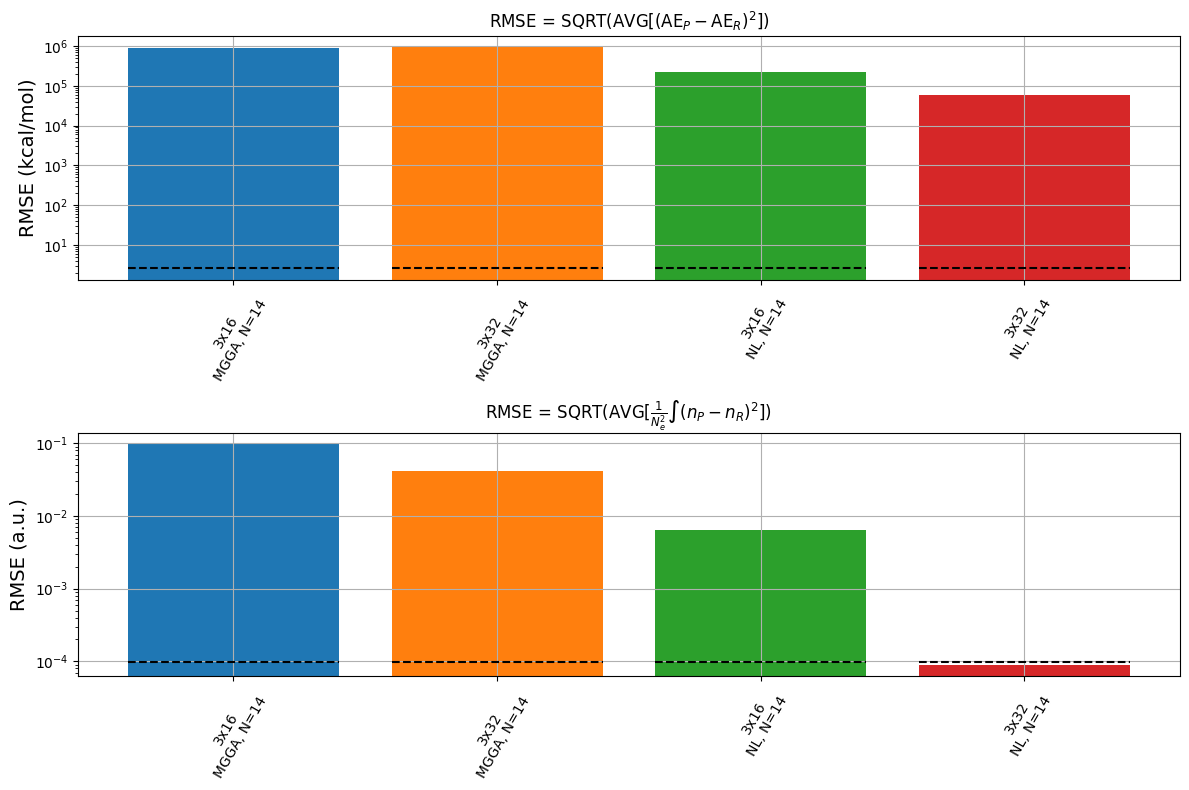

In [218]:
f = plt.figure(figsize=(12,8))
axae = f.add_subplot(211)
axdm = f.add_subplot(212)
# axaedm = f.add_subplot(313)
# axs = [axae, axdm, axaedm]
axs = [axae, axdm]
ylog = True
if ylog:
    axae.set_yscale('log')
    axdm.set_yscale('log')

pdirs = ['3_16_mgga', '3_32_mgga', '3_16_nl', '3_32_nl']
xs = np.arange(0, len(pdirs)+2)
# plabs = [labdct[pd] for pd in pdirs]
x=1
only_min = True

# om = MIN_XCD_REF
# omae = p_ae_devs
# omdm = p_dm_devs
# rmse_aes = p_ae_rmse
# rmse_dms = p_dm_rmse

om = MIN_XCD_REF3
omae = p3_ae_devs
omdm = p3_dm_devs
rmse_aes = p3_ae_rmse
rmse_dms = p3_dm_rmse

if only_min:
    plabs = [f'{i.split("_")[0]}x{i.split("_")[1]}\n{i.split("_")[-1].upper()}, N={om}' for i in pdirs]
else:
    plabs = [f'{i.split("_")[0]}x{i.split("_")[1]}\n{i.split("_")[-1].upper()}, N={rmse_aes[i][1]}' for i in pdirs]
for ax in axs:
    ax.set_xticks(xs)
    ax.set_xticklabels(['']+plabs+[''], rotation=60)
    ax.grid()

for k in rmse_aes.keys():
    if k in pdirs:
        ae_mse, N = rmse_aes[k]
        dm_mse, _ = rmse_dms[k]
        print(N)
        if only_min:
            N = om
            ae_mse = np.sqrt(np.mean(omae[k][:N]**2))*hart_to_kcal_mol
            dm_mse = np.sqrt(np.mean(omdm[k][DM_SEL][:N]**2))
            
        xcd_ae_mse = np.sqrt(np.mean(xae_devs['xcd'][:N]**2))*hart_to_kcal_mol
        xcd_dm_mse = np.sqrt(np.mean(xdm_devs['xcd'][0][:N]**2))
        print(f'xcd_ae={xcd_ae_mse}, xcd_dm={xcd_dm_mse}')
        print(ae_mse, dm_mse)
        axae.bar(x, ae_mse*hart_to_kcal_mol)
        axae.plot([x-0.4, x,x+0.4], xcd_ae_mse*np.ones(3), 'k--')
        if not ylog:
            axdm.bar(x, dm_mse*1e3)
            axdm.plot([x-0.4, x,x+0.4], xcd_dm_mse*1e3*np.ones(3), 'k--')
        else:
            axdm.bar(x, dm_mse)
            axdm.plot([x-0.4, x,x+0.4], xcd_dm_mse*np.ones(3), 'k--')
        x += 1
    
axae.set_ylabel('RMSE (kcal/mol)', fontsize=14)
axae.set_title('RMSE = $\mathrm{SQRT}(\mathrm{AVG}[({\mathrm{AE}_P - \mathrm{AE}_R})^2])$')
if not ylog:
    axdm.set_ylabel('RMSE (a.u.) $\\times 10^3$', fontsize=14)
else:
    axdm.set_ylabel('RMSE (a.u.)', fontsize=14)
axdm.set_title('RMSE = $\mathrm{SQRT}(\mathrm{AVG}[\\frac{1}{N_e^2}\int(n_P - n_R)^2])$')
plt.tight_layout()

In [185]:
p3_ae_devs

{'3_16_mgga': array([ -1.24676438,  -1.40319323,   5.09568837,  -0.62055635,
         -3.70958701,  -0.56746826,   0.57411978,   0.72321989,
          0.37408117,  -4.68078699,  -0.27474435,  -1.49003347,
         -1.42703219,  -1.93196981,   1.38266539,   1.74664258,
          3.73348561,  -1.22682332,  -1.65755962,  -0.74225441,
         -0.37928514,  -1.74285629,  -3.42726841,  -0.77652256,
        -13.07884284,  -5.04085839,  -5.59030308,  -4.44495046,
         -1.22188065,  52.17561819,  -0.49502586,  -0.30732401,
         -4.13340059,   0.14000128,  -1.2878798 ,  -0.91073241,
         -3.71526429,  -0.21840302,   3.84079561,  -2.006002  ,
         -3.08208574,  -2.8799907 ,   4.65390617,   1.28992558,
         -3.2959304 ,  -1.56758356,   0.5348688 ,   2.44811142,
         -3.40805102,   1.07735853,   0.93642026,  -2.62026118,
          0.7586077 ,  -0.15091668,  -0.3153783 ,  -2.96280261,
         -0.3938233 ]),
 '3_32_mgga': array([-1.28400411, -0.64208474,  4.5191377 , -0.6280

In [200]:
g297dir = '/home/awills/Documents/Research/xcquinox_pt/g297_val/g2_97_ccsdt'
TESTs_ae_devs = {d:0 for d in archs}
TESTs_dm_devs = {d:0 for d in archs}
TESTp_ae_devs = {d:0 for d in archs}
TESTp_dm_devs = {d:0 for d in archs}
TESTs3_ae_devs = {d:0 for d in archs}
TESTs3_dm_devs = {d:0 for d in archs}
TESTp3_ae_devs = {d:0 for d in archs}
TESTp3_dm_devs = {d:0 for d in archs}

for xcidx, xcdir in enumerate(xcs):
    for didx, bdir in enumerate(archs):
        for gidx, gdir in enumerate(grids):
            if xcdir == 'pbe0':
                if gdir == 'grid1':
                    ae_dev = TESTp_ae_devs
                    dm_dev = TESTp_dm_devs
                elif gdir == 'grid3':
                    ae_dev = TESTp3_ae_devs
                    dm_dev = TESTp3_dm_devs
            elif xcdir == 'scan':
                if gdir == 'grid1':
                    ae_dev = TESTs_ae_devs
                    dm_dev = TESTs_dm_devs
                elif gdir == 'grid3':
                    ae_dev = TESTs3_ae_devs
                    dm_dev = TESTs3_dm_devs
            print(td, xcdir, bdir, gdir)
            p = os.path.join(td, xcdir, bdir, gdir)
            print(p)
            trajs = sorted([i for i in os.listdir(p) if '_' in i and 'traj' in i], key=lambda x: int(x.split('_')[0]))
            atomic_preds = {}
            total_preds = {}
            total_atomizations = {}
            atrajs = [read(os.path.join(p, atp), ':')[0] for atp in trajs]
            NUMATOMS = 0
            for idx, at in enumerate(atrajs):
                # print(idx, at)
                syms = at.get_chemical_symbols()
                if len(syms) == 1:
                    atomic_preds[syms[0]] = at.calc.results['energy']
                    NUMATOMS += 1
                elif len(syms) > 1:
                    start_energy = at.calc.results['energy']
                    total_preds[idx] = start_energy
                    print(f'{at.get_chemical_formula()} initial energy: {start_energy}')
                    for s in syms:
                        start_energy -= atomic_preds[s]
                        print(f' - {s}:{atomic_preds[s]} = {start_energy}')
                    total_atomizations[idx] = start_energy
                    print(f'{at.get_chemical_formula()} AE pred = {start_energy}')
                    print(f'{at.get_chemical_formula()} AE ref = {-tot_ref[idx].info["atomization"]}')
            didx_ae_dev = []
            didx_dm_dev = []
            didx_dm_dev2 = []
            for fidx, at in enumerate(atrajs):
                if fidx >= NUMATOMS:
                    # print(fidx, form.get_chemical_formula())
                    # print(fidx, tot_ref[fidx].get_chemical_formula())
                    gat = tot_ref[fidx]
                    m = gen_mol(gat)
                    dmpredp = os.path.join(p, '{}_{}.dm.npy'.format(fidx, at.symbols))
                    dmrefp = os.path.join(g297dir, '{}_{}.dm.npy'.format(fidx-NUMATOMS, at.symbols))
                    
                    dmpred = np.load(dmpredp)
                    dmref = np.load(dmrefp)
            
                    if len(dmpred.shape) == 2:
                        mf = dft.UKS(m, xc='PBE,PBE')
                    else:
                        mf = dft.RKS(m, xc='PBE,PBE')
                    mf.grids.level = int(gdir[-1])
                    mf.grids.build()
                    ao_eval = mf._numint.eval_ao(m, mf.grids.coords, deriv=2)
                    nelec = np.sum(m.nelec)
                    subs = at.get_chemical_symbols()
                    energy = total_preds[fidx]
                    ae = total_atomizations[fidx]
                    gae = -gat.info['atomization']
                    print(f'{at.get_chemical_formula()} (fidx) AE pred = {ae}')
                    print(f'{at.get_chemical_formula()} (fidx) AE ref = {gae}')
                    didx_ae_dev.append( ae - gae )   
                    print(f'{fidx} -> {at.get_chemical_formula()}/{gat.get_chemical_formula()} -> {ae}-{gae} = {ae-gae}')
                    rho_pred = get_rho(dmpred, ao_eval[0], nelec=nelec)
                    rho_ref = get_rho(dmref, ao_eval[0], nelec=nelec)
                    
                    r = np.linalg.norm(mf.grids.coords, axis=1)
                    rn = np.power(r,2)  
                    combined = mf.grids.weights * rn
                    try:
                        integral1 = np.dot((rho_pred.T-rho_ref.T)**2, combined.T)/nelec**2
                        integral2 = np.dot(np.abs(rho_pred.T-rho_ref.T), combined.T)/nelec
                        print(f'{fidx} -> {at.get_chemical_formula()}/{gat.get_chemical_formula()} -> RHOL1/RHOL2 = {integral1}/{integral2}')
                    except Exception as e:
                        # print(e)
                        integral = 99
                        # print('Exception raised. probably dm shape mismatch.')
                        # print('predicted dm shape', dmpred.shape)
                        # print('reference dm shape', dmref.shape)
                        # print('predicted rho shape', rho_pred.shape)
                        # print('reference rho shape', rho_ref.shape)
                        # print('combined r^2*weights', combined.shape)
                        # print('trying combined density')
                        try:
                            if len(rho_pred.shape) == 2:
                                rho_pred = rho_pred[0]+rho_pred[1]
                            if len(rho_ref.shape) == 2:
                                rho_ref = rho_ref[0]+rho_ref[1]
                            integral1 = np.dot((rho_pred.T-rho_ref.T)**2, combined.T)/nelec**2
                            integral2 = np.dot(np.abs(rho_pred.T-rho_ref.T), combined.T)/nelec
                        except:
                            print('still didnt work. integral = 100, manually skip it')
                            integral = 100
                    didx_dm_dev.append(integral1)
                    didx_dm_dev2.append(integral2)
                ae_dev[bdir] = np.array(didx_ae_dev)
                dm_dev[bdir] = (np.array(didx_dm_dev), np.array(didx_dm_dev2))

/home/awills/Documents/Research/xcquinox_pt/g297_val pbe0 3_16_mgga grid1
/home/awills/Documents/Research/xcquinox_pt/g297_val/pbe0/3_16_mgga/grid1
CO initial energy: -107.78017877729147
 - O:-74.02861341718994 = -33.75156536010152
 - C:-33.116738150913086 = -0.6348272091884368
CO AE pred = -0.6348272091884368
CO AE ref = -0.4142335363320095
CS initial energy: -422.08925702208364
 - C:-33.116738150913086 = -388.97251887117056
 - S:-395.34189666966074 = 6.369377798490177
CS AE pred = 6.369377798490177
CS AE ref = -0.2740316507303354
H2 initial energy: 5.676715595251814
 - H:-0.709357063039333 = 6.3860726582911465
 - H:-0.709357063039333 = 7.095429721330479
H2 AE pred = 7.095429721330479
H2 AE ref = -0.17434014967795244
HF initial energy: -97.44863102005927
 - F:-97.76719938128007 = 0.3185683612207981
 - H:-0.709357063039333 = 1.0279254242601312
HF AE pred = 1.0279254242601312
HF AE ref = -0.2258693892950415
P2 initial energy: -668.8647019109034
 - P:-336.82770900477084 = -332.0369929061

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f71d619b9d0>>
Traceback (most recent call last):
  File "/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


CF4 (fidx) AE pred = -8.48443735051481
CF4 (fidx) AE ref = -0.7639345937792278
23 -> CF4/CF4 -> -8.48443735051481--0.7639345937792278 = -7.720502756735582
23 -> CF4/CF4 -> RHOL1/RHOL2 = 0.006016450582687187/1.6373967905271536
CH4 (fidx) AE pred = 3.8881003074676403
CH4 (fidx) AE ref = -0.6695182791315805
24 -> CH4/CH4 -> 3.8881003074676403--0.6695182791315805 = 4.5576185865992205
24 -> CH4/CH4 -> RHOL1/RHOL2 = 0.023889090245438303/46.87881950749001
CO2 (fidx) AE pred = -5.185008667812099
CO2 (fidx) AE ref = -0.6223386877991182
25 -> CO2/CO2 -> -5.185008667812099--0.6223386877991182 = -4.562669980012981
25 -> CO2/CO2 -> RHOL1/RHOL2 = 0.007127555537500979/1.4015863096562107
CS2 (fidx) AE pred = -4.87207565227709
CS2 (fidx) AE ref = -0.4471796463688061
26 -> CS2/CS2 -> -4.87207565227709--0.4471796463688061 = -4.424896005908284
26 -> CS2/CS2 -> RHOL1/RHOL2 = 0.015081754431207581/1.5683965615777722
F2O (fidx) AE pred = -2.1157866124545563
F2O (fidx) AE ref = -0.14956391317051176
27 -> F2O/F

KeyboardInterrupt: 